In [210]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


pd.set_option('display.max_columns', 50)

# Step 1: Load the dataset
file_path = "data/american_bankruptcy.csv"
df = pd.read_csv(file_path)
df['year'] = round(df['year'].astype(int), 0)

# Step 2: Recode the 'status_label' so that only the last observation in a panel is 'failed'
# Sort the dataset by company_name and year to ensure the panel is correctly ordered
df = df.sort_values(by=['company_name', 'year'])

# Identify the last observation for each panel
df['is_last'] = df.groupby('company_name')['year'].transform('max') == df['year']

# Recode 'status_label' based on whether it's the last observation
df['status_label'] = df.apply(lambda row: 'failed' if row['is_last'] else 'alive', axis=1)

df['status_label_2'] = 'alive'
df.loc[(df['is_last']) & (df['status_label'] == 'failed'), 'status_label_2'] = 'failed'

# Step 3: Convert 'status_label' into a boolean called 'bankrupt'
df['bankrupt'] = df['status_label_2'].map({'alive': 0, 'failed': 1})

# Drop the 'is_last' and 'status_label' columns if no longer needed
df = df.drop(columns=['is_last', 'status_label', 'status_label_2'])

In [211]:
df[df['company_name'] == 'C_998']

,company_name,year,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,bankrupt
11886,C_998,1999,1468.808,1583.195,67.649,155.058,216.857,0.440,850.888,540.3425,1891.088,3874.891,323.014,87.409,307.893,1302.406,-255.884,1891.088,3083.005,1736.030,0
11887,C_998,2000,574.528,1603.771,63.890,78.755,101.875,-22.082,268.766,651.2028,1877.753,2025.126,323.157,14.865,273.982,659.726,-285.754,1877.753,1248.523,1798.998,0
11888,C_998,2001,799.499,1715.677,60.440,110.428,108.408,-20.022,253.957,757.3903,1969.806,2103.840,100.393,49.988,254.129,976.916,-308.035,1969.806,1333.730,1859.378,0
11889,C_998,2002,762.905,1703.327,40.811,-115.120,149.848,-776.394,289.289,281.5902,1748.681,1278.171,86.104,-155.931,45.354,917.049,-1513.744,1748.681,1694.928,1863.801,0
11890,C_998,2003,698.527,2208.338,44.504,-42.738,69.485,-95.229,253.585,789.5126,2335.364,1248.874,279.682,-87.242,127.026,722.831,-1474.342,2335.364,1612.051,2378.102,0
11891,C_998,2004,799.923,1633.629,40.293,86.128,72.355,61.639,333.704,1234.1408,1923.019,1386.932,268.011,45.835,289.390,741.691,-1388.434,1923.019,1648.375,1836.891,0
11892,C_998,2005,993.099,1413.105,44.266,220.780,73.799,197.977,322.435,3203.1318,1856.311,1668.286,207.861,176.514,443.206,763.293,-1283.783,1856.311,1751.584,1635.531,0
11893,C_998,2006,2140.478,3305.921,61.000,425.696,307.915,342.299,755.683,5639.6111,4120.141,3594.187,15.242,364.696,814.220,2479.581,-879.218,4120.141,3205.807,3694.445,0
11894,C_998,2007,2757.500,4404.908,95.989,762.091,289.500,607.828,843.489,13333.1061,5631.610,4411.486,10.609,666.102,1226.702,2696.532,-146.644,5631.610,3244.481,4869.519,0
11895,C_998,2008,2216.985,5393.694,126.133,590.782,440.096,429.302,852.621,2255.9399,6527.523,4601.693,6.109,464.649,1133.829,2208.345,-107.824,6527.523,3285.521,5936.741,0


In [212]:
bankruptcy_count_by_year = df[df['bankrupt'] == 1].groupby('year').size()
#print(bankruptcy_count_by_year)

In [213]:
# Step 4: Prepare data for LDA and QDA
# Assuming variables X1-X18 are the feature columns
X = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']]
y = df['bankrupt']

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Perform LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
y_pred_lda = lda.predict(X)

# Evaluate LDA performance
lda_accuracy = accuracy_score(y, y_pred_lda)
print(f'LDA Accuracy: {lda_accuracy:.2f}')

# Step 6: Perform QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X, y)
y_pred_qda = qda.predict(X)

# Evaluate QDA performance
qda_accuracy = accuracy_score(y, y_pred_qda)
print(f'QDA Accuracy: {qda_accuracy:.2f}')

LDA Accuracy: 0.89
QDA Accuracy: 0.12


c:\Users\carso\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


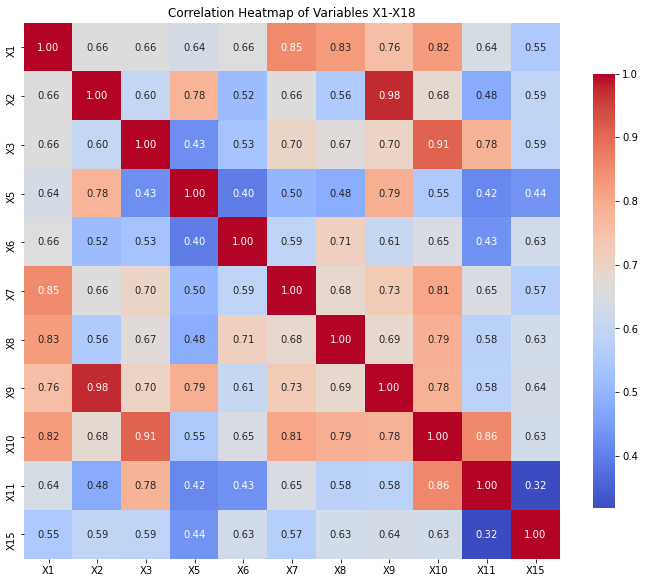

In [325]:
# Calculate the correlation matrix
corr_matrix = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 
                  'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .8})

# Customize the plot
plt.title('Correlation Heatmap of Variables X1-X18')
plt.show()

## Team Assignment 1

### Step 1: Test how well the Altman Z-Score Ratios correctly classify companies going bankrupt

In [347]:
# Calculate Altman Z-Score ratios
df["z1"] = ((df["X1"] - df["X14"]) / df["X10"]) # Working Capital / Total Assets
df["z2"] = (df["X15"] / df["X10"]) # Retained Earnings / Total Assets
df["z3"] = (df["X12"] / df["X10"]) # EBIT / Total Assets
df["z4"] = (df["X8"] / df["X17"]) # Market Value / Total Liabilities
df["z5"] = (df["X9"] / df["X10"]) # Net Sales / Total Assets

# Calculate the Altman Z-Score
df['altman_z_score'] = 1.2 * df['z1'] + 1.4 * df['z2'] + 3.3 * df['z3'] + 0.6 * df['z4'] + df['z5']
df

,company_name,year,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,bankrupt,z1,z2,z3,z4,z5,altman_z_score
0,C_1,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,372.7519,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302,0,0.468896,0.271291,0.095355,0.928438,1.382369,3.196587
1,C_1,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,377.1180,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888,0,0.513588,0.290751,0.065241,1.042794,1.245637,3.109968
2,C_1,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,364.5928,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514,0,0.402974,0.196569,0.006633,0.911564,0.899355,2.226949
3,C_1,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,143.3295,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592,0,0.280849,0.180749,0.005204,0.365979,0.883074,1.709901
4,C_1,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,308.9071,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467,0,0.424286,0.185938,0.029341,0.757853,0.919167,2.240159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11921,C_999,2014,4185.500,15446.300,1539.300,9507.100,110.000,4757.800,1214.400,90223.7300,27441.300,34281.400,14989.700,7967.800,11995.000,2747.900,41774.800,27441.300,21428.000,17934.200,0,0.041935,1.218585,0.232423,4.210553,0.800472,5.850142
11922,C_999,2015,9643.000,14185.800,1438.000,8792.900,100.100,4529.300,1298.700,107129.3520,25413.000,37938.700,24122.100,7354.900,11227.200,2950.400,41714.700,25413.000,30850.800,16620.100,0,0.176406,1.099529,0.193863,3.472498,0.669844,5.144117
11923,C_999,2016,4848.600,13026.500,1390.700,9210.900,58.900,4686.500,1474.100,99725.1960,24621.900,31023.900,25878.500,7820.200,11595.400,3468.300,43129.800,24621.900,33228.200,15411.000,0,0.044492,1.390212,0.252070,3.001222,0.793643,5.425894
11924,C_999,2017,5327.200,10972.100,1227.500,9617.000,58.800,5192.300,1976.200,136680.4920,22820.400,33803.700,29536.400,8389.500,11848.300,2890.600,46147.400,22820.400,37071.700,13203.400,0,0.072081,1.365158,0.248183,3.686923,0.675086,5.703962


In [371]:
# Define target and features
X = df[['altman_z_score']] 
y = df['bankrupt'] 

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [372]:
# Perform LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)

# Evaluate LDA performance
lda_accuracy = accuracy_score(y_test, y_pred_lda)
print(f'LDA Accuracy: {lda_accuracy:.2f}')

lda_roc_auc = roc_auc_score(y_test, lda.predict_proba(X_test)[:,1])
print("LDA_ROC-AUC Score:", lda_roc_auc)

# Evaluate the model
print("Classification Report LDA:\n", classification_report(y_test, y_pred_lda, zero_division=0))

# Perform QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_test)

# Evaluate QDA performance
qda_accuracy = accuracy_score(y_test, y_pred_qda)
print(f'QDA Accuracy: {qda_accuracy:.2f}')

qda_roc_auc = roc_auc_score(y_test, qda.predict_proba(X_test)[:,1])
print("QDA_ROC-AUC Score:", qda_roc_auc)

# Evaluate the model
print("Classification Report QDA:\n", classification_report(y_test, y_pred_qda, zero_division=0))


LDA Accuracy: 0.89
LDA_ROC-AUC Score: 0.5949318547801503
Classification Report LDA:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     20974
           1       0.00      0.00      0.00      2631

    accuracy                           0.89     23605
   macro avg       0.44      0.50      0.47     23605
weighted avg       0.79      0.89      0.84     23605

QDA Accuracy: 0.89
QDA_ROC-AUC Score: 0.45257953984548094
Classification Report QDA:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     20974
           1       0.39      0.01      0.02      2631

    accuracy                           0.89     23605
   macro avg       0.64      0.50      0.48     23605
weighted avg       0.83      0.89      0.84     23605



### Step 2: Try to Find better model

In [385]:
# Define target and features
X = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 
        'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 
        'X18','altman_z_score']] 
y = df['bankrupt'] 

# Standaradize numerical variables
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize Logistic Regression
logreg = LogisticRegression(penalty='l1', solver='liblinear')

# Train the model
logreg.fit(X_train, y_train)
# Make predictions
y_pred = logreg.predict(X_test)

# Evaluate performance
z_score_accuracy = accuracy_score(y_test, y_pred)
print(f'Z-Score Accuracy: {z_score_accuracy:.2f}')

# However, if your dataset is imbalanced (far more non-bankrupt companies than bankrupt ones), 
# accuracy may not be a reliable indicator of model performance.

Z-Score Accuracy: 0.89


In [386]:
# Calculate ROC-AUC Score
roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])
print("ROC-AUC Score:", roc_auc)

# ROC AUC (Receiver Operating Characteristic Area Under the Curve) calculates the performance of a classification model by measuring the area under the ROC curve. 
# It quantifies how well the model distinguishes positive and negative classes. A higher AUC indicates better model performance
# .5 means that is is pretty much same as random guessing

ROC-AUC Score: 0.5754762452812566


In [384]:
# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))

# Precision for Class 0 (Non-bankrupt) = 0.89: Out of all companies predicted to be non-bankrupt, 89% were actually non-bankrupt.
# Precision for Class 1 (Bankrupt) = 0.46: Out of all companies predicted to be bankrupt, only 43% were actually bankrupt.

# Recall for Class 0 (Non-bankrupt) = 1.00: The model identified all non-bankrupt companies correctly (no false negatives for this class).
# Recall for Class 1 (Bankrupt) = 0.00: The model failed to identify any bankrupt companies correctly (it predicted none of the bankrupt companies correctly).

# Class 0 is probably good because there are much more non_bankrupt and bankrupt companies in dataset

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     20974
           1       0.40      0.00      0.00      2631

    accuracy                           0.89     23605
   macro avg       0.64      0.50      0.47     23605
weighted avg       0.83      0.89      0.84     23605



### Part 3: Does model hold over time through a financial Crisis


In [373]:
# spereate data before and after the 2008 financial crisis
before_crisis = df[df['year'] < 2008]
after_crisis = df[df['year'] >= 2008]

# Define target and features
before_X = before_crisis[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 
                        'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 
                        'X18','altman_z_score']] 
before_y = before_crisis['bankrupt'] 

# Define target and features
after_X = after_crisis[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 
                        'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 
                        'X18','altman_z_score']] 
after_y = after_crisis['bankrupt'] 

# Standaradize numerical variables for after the crisis data
before_scaler = StandardScaler()
before_X = scaler.fit_transform(before_X)

# Standaradize numerical variables for before the crisis data
after_scaler = StandardScaler()
after_X = scaler.fit_transform(after_X)

# Split the data
before_X_train, before_X_test, before_y_train, before_y_test = train_test_split(before_X, before_y, test_size=0.2, random_state=42)
after_X_train, after_X_test, after_y_train, after_y_test = train_test_split(after_X, after_y, test_size=0.2, random_state=42)

In [374]:
# Initialize Logistic Regression
before_logreg = LogisticRegression(penalty='l2', solver='liblinear')
after_logreg = LogisticRegression(penalty='l2', solver='liblinear')

# Train the model for before the crisis
before_logreg.fit(before_X_train, before_y_train)
# Make predictions for before the crisis
before_y_pred = before_logreg.predict(before_X_test)

# Train the model for after the crisis
after_logreg.fit(after_X_train, after_y_train)
# Make predictions for after the crisis
after_y_pred = after_logreg.predict(after_X_test)

# Calculate ROC-AUC Score
before_roc_auc = roc_auc_score(before_y_test, before_logreg.predict_proba(before_X_test)[:,1])
print("Before Crisis ROC-AUC Score:", before_roc_auc)

after_roc_auc = roc_auc_score(after_y_test, after_logreg.predict_proba(after_X_test)[:,1])
print("After Crisis ROC-AUC Score:", after_roc_auc)

# looks like the model predicts bankrupcty a little better before the financial crisis.

Before Crisis ROC-AUC Score: 0.6286603546779174
After Crisis ROC-AUC Score: 0.5803595125571438


In [375]:
# Evaluate the model
print("Classification Report Before Crisis:\n", classification_report(before_y_test, before_y_pred))

print("Classification Report After Crisis:\n", classification_report(after_y_test, after_y_pred))

Classification Report Before Crisis:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      7612
           1       0.00      0.00      0.00       626

    accuracy                           0.92      8238
   macro avg       0.46      0.50      0.48      8238
weighted avg       0.85      0.92      0.89      8238

Classification Report After Crisis:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92      6359
           1       0.67      0.00      0.00      1140

    accuracy                           0.85      7499
   macro avg       0.76      0.50      0.46      7499
weighted avg       0.82      0.85      0.78      7499

